In [123]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PATH="Assets/Data/"

In [124]:
import json
import pandas as pd

with open(PATH+"swarmData.json", "r") as f:
    data = json.load(f)

rows = []

# Read top-level constants (if you want them in every row)
max_speed = data.get("maxSpeed", None)
max_force = data.get("maxForce", None)
neighbor_radius = data.get("neighborRadius", None)
alpha = data.get("alpha", None)
beta = data.get("beta", None)
delta = data.get("delta", None)
avoidance_radius = data.get("avoidanceRadius", None)
avoidance_force = data.get("avoidanceForce", None)
drone_radius = data.get("droneRadius", None)
damping_factor = data.get("dampingFactor", None)

In [125]:
max_force = 20

In [126]:

rows = []

for drone_entry in data["swarmState"]:
    drone_id = int(drone_entry["droneId"])
    drone_state = drone_entry["droneState"]

    positions = drone_state.get("position", [])
    velocities = drone_state.get("velocity", [])
    obstacles = drone_state.get("obstacleAvoidance", [])
    allignement = drone_state.get("alignment", [])
    olfati = drone_state.get("olfatiSaber", [])
    embodied_list = drone_state.get("embodied", [])
    selected_list = drone_state.get("selected", [])
    network_list = drone_state.get("network", [])

    # Determine how many time steps exist for this drone
    number_of_time_steps = max(
        len(positions),
        len(velocities),
        len(embodied_list),
        len(selected_list),
        len(network_list)
    )

    for i in range(number_of_time_steps):
        # Fetch the position dictionary if it exists, otherwise {}
        if i < len(positions) and isinstance(positions[i], dict):
            pos = positions[i]
            posX = pos.get("x", None)
            posY = pos.get("y", None)
            posZ = pos.get("z", None)
        else:
            posX, posY, posZ = None, None, None

        # Fetch the velocity dictionary if it exists, otherwise {}
        if i < len(velocities) and isinstance(velocities[i], dict):
            vel = velocities[i]
            velX = vel.get("x", None)
            velY = vel.get("y", None)
            velZ = vel.get("z", None)
        else:
            velX, velY, velZ = None, None, None

        if i < len(obstacles) and isinstance(obstacles[i], dict):
            obs = obstacles[i]
            obsX = obs.get("x", None)
            obsY = obs.get("y", None)
            obsZ = obs.get("z", None)

        if i < len(olfati) and isinstance(olfati[i], dict):
            olf = olfati[i]
            olfX = olf.get("x", None)
            olfY = olf.get("y", None)
            olfZ = olf.get("z", None)

        if i < len(allignement) and isinstance(allignement[i], dict):
            all = allignement[i]
            allX = all.get("x", None)
            allY = all.get("y", None)
            allZ = all.get("z", None)

        # Booleans or other single-value lists
        emb = embodied_list[i] if i < len(embodied_list) else None
        sel = selected_list[i] if i < len(selected_list) else None
        net = network_list[i] if i < len(network_list) else None

        row_data = {
            "droneId": drone_id,
            "timeStep": i,
            "posX": posX,
            "posY": posY,
            "posZ": posZ,
            "velX": velX,
            "velY": velY,
            "velZ": velZ,
            "obsX": obsX,
            "obsY": obsY,
            "obsZ": obsZ,
            "olfX": olfX,
            "olfY": olfY,
            "olfZ": olfZ,
            "allX": allX,
            "allY": allY,
            "allZ": allZ,
            "embodied": emb,
            "selected": sel,
            "network": net
        }
        rows.append(row_data)

df = pd.DataFrame(rows)

In [103]:
# fo = Vector3.ClampMagnitude(fo, maxForce);
df['forceMagReal'] = ((df['olfX'] + df['obsX'] + df['allX'])**2 + (df['olfY'] + df['obsY'] + df['allY'])**2 + (df['olfZ'] + df['obsZ'] + df['allZ'])**2)**0.5
df['AppliedForce'] = df['forceMagReal'].apply(lambda x: min(x, max_force))

In [104]:
droneDied = []

lifeLong = df.groupby("droneId").count()[["timeStep"]]
maxLife = lifeLong["timeStep"].max()

for drone in lifeLong.index:
    if lifeLong.loc[drone]["timeStep"] < maxLife:
        droneDied.append([drone, lifeLong.loc[drone]["timeStep"]])



In [105]:
df["crash"] = 0

for drone in droneDied:
    id = drone[0]
    timeStart = int(drone[1] - 100)
    print(id, timeStart)

    df.loc[(df["droneId"] == id) & (df["timeStep"] >= timeStart), "crash"] = 1


3 694
14 694


In [113]:
dfCrash = df.query("crash == 1")[["obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", 'allX', 'allY', 'allZ', 'forceMagReal', 'AppliedForce', 'droneId']]   
dfHealthy = df.query("crash == 0")[["obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", 'allX', 'allY', 'allZ', 'forceMagReal', 'AppliedForce', 'droneId']]

In [114]:
dfCrash.describe()



,obsX,obsY,obsZ,olfX,olfY,olfZ,allX,allY,allZ,forceMagReal,AppliedForce,droneId
count,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-6.029036,0.0,0.797804,4.491247,-0.257129,-1.819122,-1.317130,0.001206,-1.174051,10.296305,9.918914,8.500000
std,8.585726,0.0,6.653329,4.738765,1.999677,9.057088,8.187558,0.182000,1.949370,6.609481,4.675894,5.513802
min,-29.648600,0.0,-10.791206,-3.955207,-19.409061,-50.333958,-10.751967,-0.374103,-4.981463,1.757492,1.757492,3.000000
25%,-7.203867,0.0,-2.967621,-0.113823,-0.728147,-7.514035,-7.760462,-0.157257,-2.501281,5.642883,5.642883,3.000000
50%,-2.231899,0.0,0.000000,3.784298,-0.313143,-1.173606,-6.268398,0.027845,-1.000105,9.206354,9.206354,8.500000
75%,0.000000,0.0,0.000000,7.969631,0.305167,4.027247,8.071795,0.094008,0.158376,13.387489,13.387489,14.000000
max,0.000000,0.0,18.329676,13.460823,16.373459,54.362892,11.548463,0.483316,3.593279,58.305682,20.000000,14.000000


In [115]:
dfHealthy.describe()

,obsX,obsY,obsZ,olfX,olfY,olfZ,allX,allY,allZ,forceMagReal,AppliedForce,droneId
count,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000
mean,-0.695459,0.031000,-0.084944,-0.028640,0.001711,0.011294,3.016512,-0.016556,-0.027358,7.262940,7.166273,9.562488
std,3.963739,0.493348,4.499272,3.472877,2.142470,5.022369,5.507462,0.537851,1.990994,5.106062,3.449297,5.776861
min,-58.588226,-0.000011,-27.655655,-56.707062,-25.914938,-417.368805,-15.363005,-2.838442,-9.922988,0.237624,0.237624,0.000000
25%,0.000000,0.000000,0.000000,-1.599015,-0.984480,-1.532594,0.343787,-0.262824,-0.676887,4.987226,4.987226,5.000000
50%,0.000000,0.000000,0.000000,-0.098333,0.014383,-0.017861,5.233755,-0.008987,0.025411,6.344211,6.344211,9.500000
75%,0.000000,0.000000,0.000000,1.208205,1.029857,1.515723,6.159560,0.242382,0.897188,8.689613,8.689613,15.000000
max,9.490198,12.014109,28.716221,50.998463,31.128456,419.549591,13.705853,2.968811,10.162262,424.462045,20.000000,19.000000


IndexError: index 2 is out of bounds for axis 0 with size 2

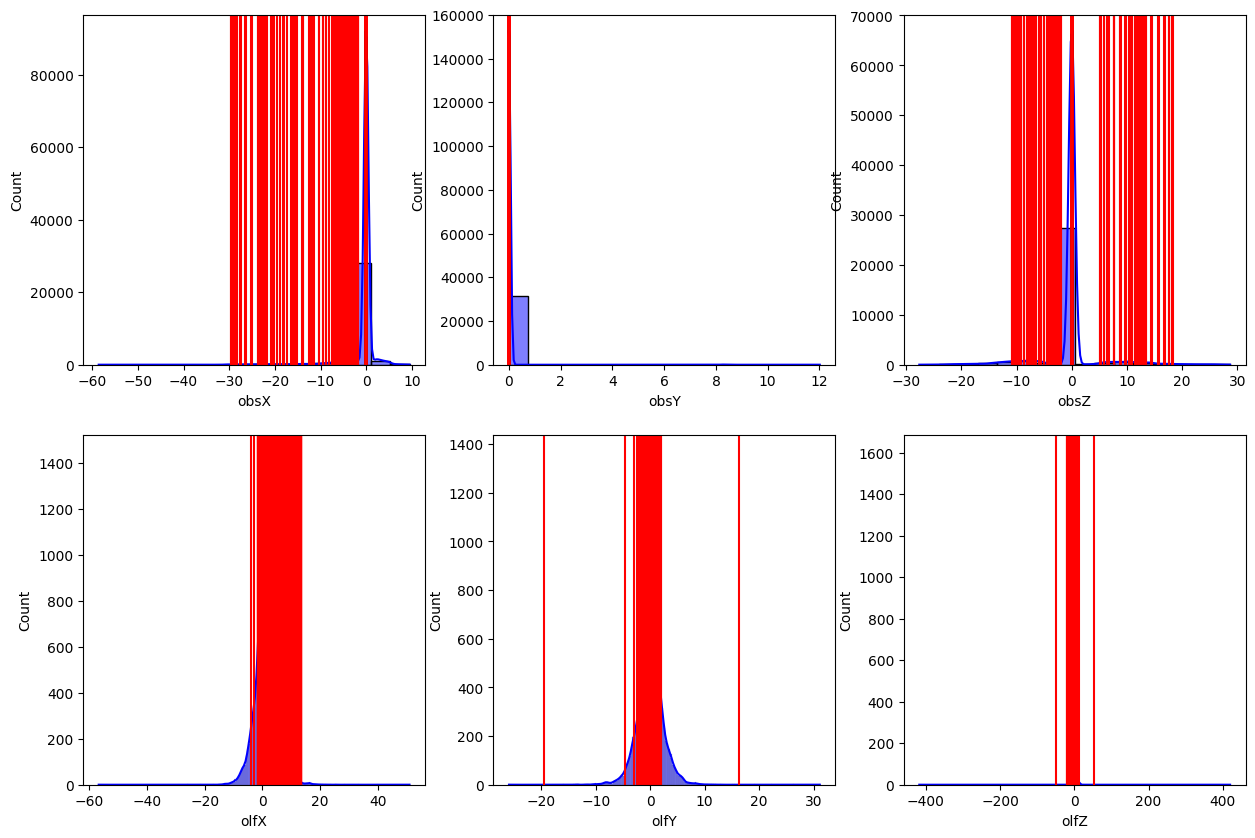

In [116]:
#make histograms of dhHealthy and foreach data point in dfCrash plot a red line to the corresponding to the value

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(dfHealthy.columns):
    sns.histplot(dfHealthy[col], ax=ax[i//3, i%3], kde=True, color="blue")
    for val in dfCrash[col]:
        ax[i//3, i%3].axvline(val, color="red")

plt.show()


In [122]:
dfHealthy.describe()

,obsX,obsY,obsZ,olfX,olfY,olfZ,allX,allY,allZ,forceMagReal,AppliedForce,droneId
count,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000,31718.000000
mean,-0.695459,0.031000,-0.084944,-0.028640,0.001711,0.011294,3.016512,-0.016556,-0.027358,7.262940,7.166273,9.562488
std,3.963739,0.493348,4.499272,3.472877,2.142470,5.022369,5.507462,0.537851,1.990994,5.106062,3.449297,5.776861
min,-58.588226,-0.000011,-27.655655,-56.707062,-25.914938,-417.368805,-15.363005,-2.838442,-9.922988,0.237624,0.237624,0.000000
25%,0.000000,0.000000,0.000000,-1.599015,-0.984480,-1.532594,0.343787,-0.262824,-0.676887,4.987226,4.987226,5.000000
50%,0.000000,0.000000,0.000000,-0.098333,0.014383,-0.017861,5.233755,-0.008987,0.025411,6.344211,6.344211,9.500000
75%,0.000000,0.000000,0.000000,1.208205,1.029857,1.515723,6.159560,0.242382,0.897188,8.689613,8.689613,15.000000
max,9.490198,12.014109,28.716221,50.998463,31.128456,419.549591,13.705853,2.968811,10.162262,424.462045,20.000000,19.000000


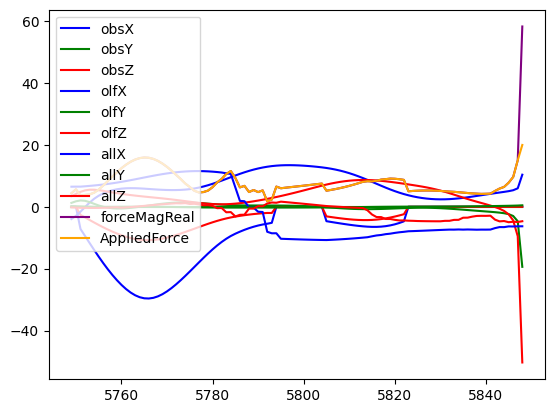

In [120]:
dfCrash.query("droneId == @droneDied[0][0]")[["obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", 'allX', 'allY', 'allZ', 'forceMagReal', 'AppliedForce']].plot(     
    color={
        'obsX': 'blue', 'olfX': 'blue',
        'obsY': 'green', 'olfY': 'green', 'allY': 'green',
        'obsZ': 'red', 'olfZ': 'red', 'allZ': 'red',
        'forceMagReal': 'purple', 'AppliedForce': 'orange',

    }
)
plt.show()

In [88]:
dfCrash['droneId'].unique()

array([ 2,  3,  7,  9, 15, 18])

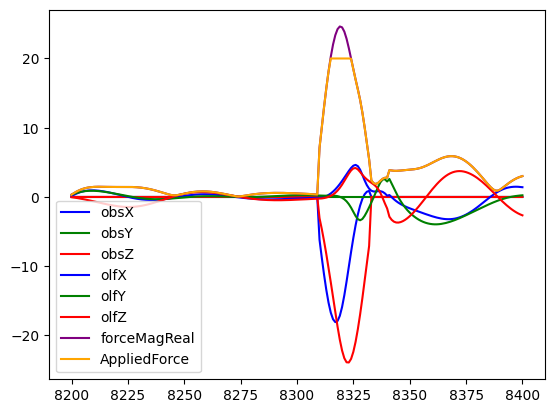

In [92]:
DronePlotted = 4
dfPlot = dfHealthy.query("droneId == @DronePlotted")


dfPlot.loc[8200:8400][["obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", 'forceMagReal', 'AppliedForce']].plot(
    color={
        'obsX': 'blue', 'olfX': 'blue',
        'obsY': 'green', 'olfY': 'green',
        'obsZ': 'red', 'olfZ': 'red',
        'forceMagReal': 'purple', 'AppliedForce': 'orange'
    }
)
plt.show()